# Bias evaluation

In this notebook, in the first part we implement and explore bias metrics for initial and hard-debiased versions of embeddings:
- L2 distance
- Cosine similarity[8]
- MAC[4]
- Direct and Indirect Bias[1]
- WEAT[2]
- WEFAT[2]
- SAME[8]
- ECT[9]
- Classification accuracy on SVM and KMeans[1]
- Bias analogy test[9]

Analyzed embeddings:
- Word2Vec[6]  with vectors of length 300 trained on GoogleNews
- Its debiased version[1] from: https://github.com/tolga-b/debiaswe
- Glove[7]
- Debiased Glove

In the second part, we implement the SEAT[5] method for contextualized BERT[3] embedding and test it against attribute word groups related to career/family, science/art, and math/art. We also study the influence of the context ("he" and "she") on profession words and measure the values of the WEAT[2] test for sentences like "She is a doctor" and "He is a doctor".

In [2]:
# initialize paths to our embeddings
path_biased = "../bias_data/glove.6B.300d.txt" 
path_debiased = "../bias_data/1b-vectors300-0.8-0.8.txt"

In [3]:
import numpy as np
from tqdm import tqdm
import scipy
from matplotlib import pyplot as plt 
import os
import pandas as pd
import seaborn as sns 

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score as accuracy
from sklearn.cluster import KMeans

from gensim.models import KeyedVectors
sns.set()

To conduct tests, we rely on groups of attribute words that reflect gender stereotypes. By evaluating the distances between attribute embeddings, we can identify patterns in the vector space of words.

In [11]:
words_m = ["male", "man", "boy", "brother", "he", "him", "his", "son"]
words_f = ["female", "woman", "girl", "sister", "she", "her", "hers", "daughter"]
attributes_career = ['executive', 'management', 'professional','corporation','salary','office','business','career']
attributes_family = ['home','parents','children','family','cousins','marriage','wedding','relatives']
attributes_art = ["poetry","art","dance","literature","novel","symphony","drama","sculpture"]
attributes_math = ["math","algebra","geometry","calculus","equations","computation","numbers","addition"]
attributes_science = ["science","technology","physics","chemistry","experiment","astronomy"]
professions = ["nurse", "hairdresser", "cook", "teacher", "pilot", "engineer", "doctor", "driver", "ballerina", 
               "officer", "pharmacist", "investigator", "commentator", "footballer", "researcher", "stylist", "historian"]
attributes_indirect = ["housekeeper", "football", "softball"]
all_words = words_m + words_f + attributes_career + attributes_art + attributes_family + attributes_math + attributes_science +\
    professions + attributes_indirect

attributes = {"career": attributes_career, "family": attributes_family, "art": attributes_art, "math":
             attributes_math, "science": attributes_science}
save_results = {"biased": {}, "debiased": {}}

In [12]:
def load_vocab(path):
    """
    Load vocabulary embeddiing. 
    """
    vocab = {}
    with open(path) as voc:
        for idx, line in tqdm(enumerate(voc)):
            if idx > 0:
                split_line = line.split()
                curr_word = split_line[0]
                if curr_word in all_words: 
                    vocab[curr_word] = np.array(split_line[1:], dtype=np.float64)
    return vocab 

In [6]:
BIASED = load_vocab(path_biased)
EMBED_WORDS_VOC = load_vocab(path_debiased)
get_embeds_debiased = lambda words: np.array([EMBED_WORDS_VOC[w] for w in words])
get_embeds_biased = lambda words: np.array([BIASED[w] for w in words])

400000it [00:14, 26960.29it/s]
142527it [00:05, 27913.49it/s]


In [7]:
male_biased, female_biased = np.mean(get_embeds_biased(words_m), 0), np.mean(get_embeds_biased(words_f), 0)
male_debiased, female_debiased = np.mean(get_embeds_debiased(words_m), 0), np.mean(get_embeds_debiased(words_f), 0)

## L2 distance 

$L_2 (p, q) = \sqrt {\sum_{k=1}^n {(p_k - q_k)^2}}$

Embeddings are vectors, the semantic similarity between which can be determined using classical metrics used in linear algebra, such as the Euclidean metric. [10]

In [13]:
def L2distance(x, y):
    return np.linalg.norm(x - y)

In [14]:
def fill_vocab(name_func, func, save_results):
    """
    Add results to results vocabulary.
    """
    save_results["biased"][name_func], save_results["debiased"][name_func] = {}, {}
    for attr in list(attributes.keys()):
        
        save_results["biased"][name_func][attr] = \
                (np.mean([func(male_biased, elem) for elem in get_embeds_biased(attributes[attr])], 0), \
                np.mean([func(female_biased, elem) for elem in get_embeds_biased(attributes[attr])], 0))

        save_results["debiased"][name_func][attr] = \
                (np.mean([func(male_debiased, elem) for elem in get_embeds_debiased(attributes[attr])], 0), \
                 np.mean([func(female_debiased, elem) for elem in get_embeds_debiased(attributes[attr])], 0))
    return save_results 

In [15]:
save_results = fill_vocab("L2", L2distance, save_results)

In [16]:
# simple test 
"Biased:", np.mean([L2distance(BIASED["he"], elem) for elem in get_embeds_biased(attributes_career)]), np.mean([L2distance(BIASED["she"], elem) for elem in get_embeds_biased(attributes_career)])

('Biased:', 7.071514028724281, 7.876539448649923)

In [17]:
"Debiased:", np.mean([L2distance(EMBED_WORDS_VOC["he"], elem) for elem in get_embeds_debiased(attributes_career)]), np.mean([L2distance(EMBED_WORDS_VOC["she"], elem) for elem in get_embeds_debiased(attributes_career)])

('Debiased:', 7.325982427932202, 8.02060934210655)

However, the Euclidean metric in the case of unnormalized vectors reflects the magnitude, and not the angle, which in the space of words is less important than the scalar product of vectors. This conclusion is based on the property of embeddings to reflect semantic relationships in the form of directions. In this regard, the following metrics will be based on cosine similarity.

### Occupations gender bias 

As an example of a comparison based on the Euclidean metric, we analyzed the distance between job embeddings and $he$ and $she$ vectors. The graph below shows a comparison of initial and debyased embeddings. The x-axis shows L2 distance between the vector representation of the word $he$ and the representations of professions, the y-axis between the representation of the word $she$ and the same professions. Accordingly, the farther from the origin along the x-axis the profession is represented, the greater the difference with the word $he$, that is, the less it corresponds to the stereotypes about the "male" profession, similarly for the y-axis.

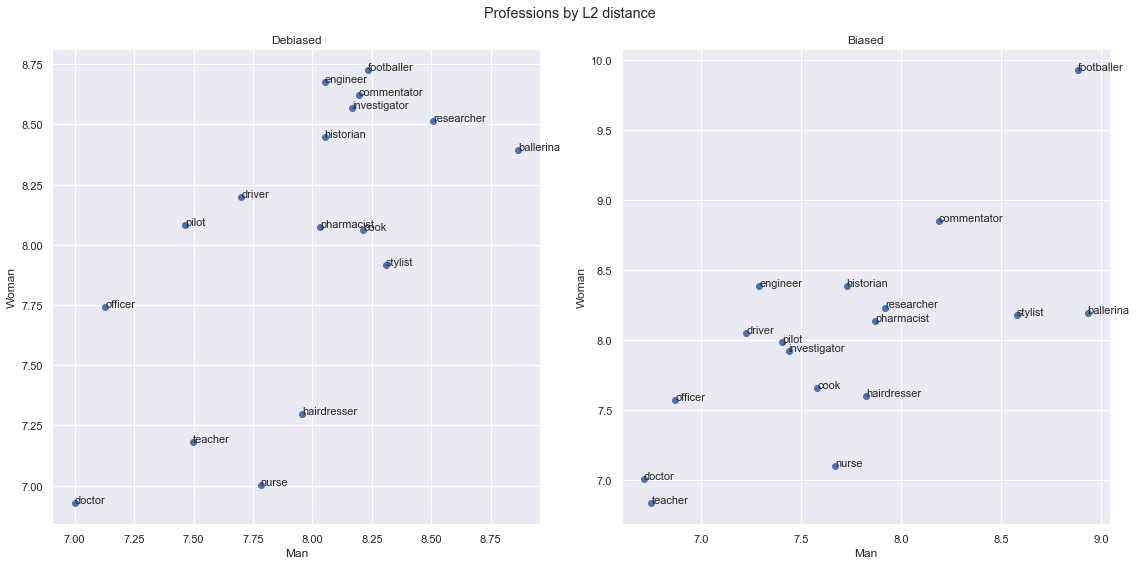

In [18]:
x, y, x_b, y_b = [], [], [], [] 
for elem in get_embeds_debiased(professions): 
    x.append(L2distance(elem, EMBED_WORDS_VOC["he"]))
    y.append(L2distance(elem, EMBED_WORDS_VOC["she"]))
    
for elem in get_embeds_biased(professions): 
    x_b.append(L2distance(elem, BIASED["he"]))
    y_b.append(L2distance(elem, BIASED["she"]))

fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].scatter(x, y)
ax[1].scatter(x_b, y_b)
ax[0].set_title("Debiased")
ax[1].set_title("Biased")
for i in range(2):
    ax[i].set_xlabel("Man")
    ax[i].set_ylabel("Woman")

for i, txt in enumerate(professions):
    ax[0].annotate(txt, (x[i], y[i]), fontsize=11)
    ax[1].annotate(txt, (x_b[i], y_b[i]), fontsize=11)
    
plt.suptitle("Professions by L2 distance")
plt.tight_layout()

As a result, for debiased embeddings, most of the professions lined up in a single line. For the initial set, a linear relationship can be identified, with the exception of a group of professions such as *engineer, football player and historian*, which are grouped away from the general linear relationship. The results obtained can be interpreted as the preservation of stereotypes about "non-female" professions in the initial set of vectors.   

## Cosine similarity 

$S_c(p, q) = \frac{\sum_{k=1}^n {p_k q_k}}{\sqrt{\sum_{k=1}^n {q_k^2}}\sqrt{\sum_{k=1}^n {p_k^2}}}$

The basis of many metrics for assessing bias in the vector representation of words is cosine similarity [8]. Due to the ability to determine the direction of vectors even in the case of a difference in magnitudes, this metric allows us to measure the similarity of the directions of words, and hence the correlation of their semantic representation.

In [19]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [20]:
save_results["biased"]["cos"], save_results["debiased"]["cos"] = {}, {}
for attr in list(attributes.keys()):
    save_results["biased"]["cos"][attr] = \
            (cosine_similarity(BIASED["he"], np.mean(get_embeds_biased(attributes[attr]), 0)), \
             cosine_similarity(BIASED["she"], np.mean(get_embeds_biased(attributes[attr]), 0)))
    
    save_results["debiased"]["cos"][attr] = \
            (cosine_similarity(EMBED_WORDS_VOC["he"], np.mean(get_embeds_debiased(attributes[attr]), 0)),
             cosine_similarity(EMBED_WORDS_VOC["she"], np.mean(get_embeds_debiased(attributes[attr]), 0)))

The distance between the vector representation of 2 words may not necessarily be due to the manifestation of gender stereotypes. To level possible side effects, it is necessary to expand the set of attribute words in relation to which testing is carried out.

## Mean Average Cosine

$MAC(T, A) = \frac{1}{N} \sum_{t \in T} \sum_{A_j \in A} S(t, A_j),$

where $S(t, A_j)= \frac{1}{N} \sum_{a \in A_j} 1 -\cos(t, a). $

This metric (Manzini et al.[4]) calculates the average distance between words and a group of attributes, which makes it possible to conclude that the term is related to a whole group of words, combined in our case by gender stereotype.

In [21]:
def MAC(words, attributes):
    if type(words) != list:
        words = [words]
    return np.mean([[cosine_similarity(w, at) for w in words] for at in attributes])

In [22]:
save_results = fill_vocab("mac", MAC, save_results)

However, MAC uses the direct associations instead of contrasting terms (Caliskan et al. [2]) or measuring the correlation with a bias direction (Bolukbasi et al. [1]), so researchers use it mostly for multi-class problems.

## Direct and indirect bias 

### Direct bias

$DirectBias(N, g) = \frac{1}{|N|} \sum_{w \in N} |\cos(w, g)|$

where $g$ - bias direction (embeddings of $\it{she} - \it{he}$) , $N$ - set of words. 

This metric describes the ratio of word representations to the direction of the bias, expressed as the difference between the representations of words $he$ and $she$ [1]. By minimizing this distance, debiasing according to the geometric definition of bias can be achieved.

In [23]:
def direct_bias(words, gender_direction): 
    return np.mean([cosine_similarity(word, gender_direction)for word in words])

In [24]:
gender_direction_biased = female_biased - male_biased
gender_direction_debiased = female_debiased - male_debiased

In [25]:
save_results["biased"]["direct"], save_results["debiased"]["direct"] = {}, {}
for attr in list(attributes.keys()):
    save_results["biased"]["direct"][attr] = \
            direct_bias(get_embeds_biased(attributes[attr]), gender_direction_biased)
    
    save_results["debiased"]["direct"][attr] = \
            direct_bias(get_embeds_debiased(attributes[attr]), gender_direction_debiased)

### Indirect bias 

In addition to direct bias, indirect bias can also be detected in embeddings. It is based on the observation that some relationships in words that are not directly related to gender stereotypes turn out to be connected by patterns [1]. For example, embedding *receptionist* is closer to word *softball* than *football* that can be explained by gender stereotype. We are trying to identify these patterns.

In [26]:
print("Biased:")
print("    Housekeeper and football", cosine_similarity(BIASED["housekeeper"], BIASED["football"]))
print("    Housekeeper and softball", cosine_similarity(BIASED["housekeeper"], BIASED["softball"]))

print("Debiased:")
print("    Housekeeper and football", cosine_similarity(EMBED_WORDS_VOC["housekeeper"], EMBED_WORDS_VOC["football"]))
print("    Housekeeper and softball", cosine_similarity(EMBED_WORDS_VOC["housekeeper"], EMBED_WORDS_VOC["softball"]))

Biased:
    Housekeeper and football -0.028229338929222254
    Housekeeper and softball 0.057039989125722154
Debiased:
    Housekeeper and football -0.058960155185892524
    Housekeeper and softball 0.03687973963252751


## Word Embedding Association Test 

$WEAT(w, A, B) = \frac{1}{n} \sum_{a \in A} \cos(w, a) - \frac{1}{n} \sum_{b \in B} \cos(w, b)$

This test (Caliskan et al. [2]) is based on the Implicit Association Test which measures reaction times analyzing stereotypical associations.

WEAT compares 2 sets of target words with 2 sets of words-attributes. Target words represent embeddings related to gender identification (A = words_m in our notation, B = words_f). Attributes demonstrate bias in relation to affinities towards stereotypic topics like X=science and Y=art. In a gender-biased vector space the scientific targets are expected to be more strongly associated with male attributes, and artistic targets with female terms.

In [27]:
def attribute_dist(w, X, Y):
    return np.mean([cosine_similarity(w, x) for x in X]) - np.mean(
            [cosine_similarity(w, y) for y in Y])

def WEAT(target1, target2, attr1, attr2):
    return np.sum([attribute_dist(t1, attr1, attr2) for t1 in target1]) \
           - np.sum([attribute_dist(t2, attr1, attr2) for t2 in target2])

def effective_size_weat(target1, target2, attr1, attr2):
    return (np.mean([attribute_dist(t1, attr1, attr2) for t1 in target1]) -
            np.mean([attribute_dist(t2, attr1, attr2) for t2 in target2])
           ) / np.std([attribute_dist(w, attr1, attr2) for w in np.append(target1, target2)])

In [28]:
save_results["biased"]["weat"], save_results["debiased"]["weat"] = {}, {}

for man_attr, woman_attr in zip(["career", "math", "science"], ["family", "art", "art"]):
    save_results["biased"]["weat"][f"{man_attr}-{woman_attr}"] = \
        WEAT(get_embeds_biased(words_m), get_embeds_biased(words_f), get_embeds_biased(attributes[man_attr]),\
             get_embeds_biased(attributes[woman_attr]))
    save_results["debiased"]["weat"][f"{man_attr}-{woman_attr}"] = \
        WEAT(get_embeds_debiased(words_m), get_embeds_debiased(words_f), get_embeds_debiased(attributes[man_attr]),\
             get_embeds_debiased(attributes[woman_attr]))

This is one of the most common bias measurement metrics based on 2 sets of target trems and 2 sets of attribute words. Depending on these sets, one can determine the nature of the bias: in relation to science, art, family values, career, etc.

## Word-Embedding Factual Association Test

$WEFAT(w, A, B) = \frac{mean_{a \in A} \cos(w, a) -  mean_{b \in B} \cos(w, b)} {std_{x \in A \cup B \cos(w, x)}}$

The WEFAT[2] is a standardized effect size measure of the difference in two distributions of associations between a single target word and two sets of attributes.

In [29]:
def WEFAT(w, attr1, attr2): 
    return attribute_dist(w, attr1, attr2) / np.std([cosine_similarity(w, x) for x in np.append(attr1, attr2)])

In [30]:
save_results["biased"]["wefat"], save_results["debiased"]["wefat"] = {}, {}

for man_attr, woman_attr in zip(["career", "math", "science"], ["family", "art", "art"]):
    save_results["biased"]["wefat"][f"{man_attr}-{woman_attr}"] = \
        (WEFAT(male_biased, get_embeds_biased(attributes[man_attr]), get_embeds_biased(attributes[woman_attr])),\
         WEFAT(female_biased, get_embeds_biased(attributes[man_attr]), get_embeds_biased(attributes[woman_attr])))
    save_results["debiased"]["wefat"][f"{man_attr}-{woman_attr}"] = \
        (WEFAT(male_debiased, get_embeds_debiased(attributes[man_attr]), get_embeds_debiased(attributes[woman_attr])),\
         WEFAT(female_debiased, get_embeds_debiased(attributes[man_attr]), get_embeds_debiased(attributes[woman_attr])))

## Scoring Association Means of Word Embeddings

$SAME(w, A_i, A_j) = \cos (w, \hat{a}_i - \hat{a}_j)$

where $\hat{a}_i = \frac {1}{|A_i|} \sum_{a_i \in A_i}a_i$

SAME (Schröder et al. [8]) has a similar intuition to WEAT, in terms of measuring polarity between attribute sets, but sensitive to both skew and stereotype. 

In [31]:
def SAME(words, attr1, attr2):
    return np.mean([np.abs(cosine_similarity(w, np.mean(attr1, 0) - np.mean(attr2, 0))) for w in words])

In [32]:
save_results["biased"]["same"], save_results["debiased"]["same"] = {}, {}

for man_attr, woman_attr in zip(["career", "math", "science"], ["family", "art", "art"]):
    save_results["biased"]["same"][f"{man_attr}-{woman_attr}"] = \
        (SAME(get_embeds_biased(words_m), get_embeds_biased(attributes[man_attr]), get_embeds_biased(attributes[woman_attr])),\
         SAME(get_embeds_biased(words_f), get_embeds_biased(attributes[man_attr]), get_embeds_biased(attributes[woman_attr])))
    
    save_results["debiased"]["same"][f"{man_attr}-{woman_attr}"] = \
        (SAME(get_embeds_debiased(words_m), get_embeds_debiased(attributes[man_attr]), get_embeds_debiased(attributes[woman_attr])),\
         SAME(get_embeds_debiased(words_f), get_embeds_debiased(attributes[man_attr]), get_embeds_debiased(attributes[woman_attr])))

The score is magnitude-comparable and sensitive both to skew and stereotype, so it is reliable metrics to quantify bias in embeddings and can be compared between different embeddings.

## Embedding Coherence Test

$ECT = Spearman([cos(w, mean(T_1)), w \in A_1 \cup A_2], [cos(w, mean(T_2)), w \in A_1 \cup A_2])$

ECT quantifies the amount of explicit bias based on 2 target sets and only 1 attribute set [9]. Firstly, it computes the mean vectors for the target sets and the cosine similarities with vectors of all attribute-words. The similarity scores are used to obtain the Spearman’s rank correlation. 

In [33]:
def ECT(target1, target2, attr1, attr2):
    mean1, mean2 = np.mean(target1, 0), np.mean(target2, 0)  # shape of target1[0]
    attr = np.append(attr1, attr2, axis=0)
    cos_sim1 = [cosine_similarity(elem, mean1) for elem in attr]
    cos_sim2 = [cosine_similarity(elem, mean2) for elem in attr]
    return scipy.stats.spearmanr(cos_sim1, cos_sim2)

In [34]:
save_results["biased"]["ect"], save_results["debiased"]["ect"] = {}, {}

for man_attr, woman_attr in zip(["career", "math", "science"], ["family", "art", "art"]):
    save_results["biased"]["ect"][f"{man_attr}-{woman_attr}"] = \
        ECT(get_embeds_biased(words_m), get_embeds_biased(words_f), get_embeds_biased(attributes[man_attr]),\
             get_embeds_biased(attributes[woman_attr]))
    save_results["debiased"]["ect"][f"{man_attr}-{woman_attr}"] = \
        ECT(get_embeds_debiased(words_m), get_embeds_debiased(words_f), get_embeds_debiased(attributes[man_attr]),\
             get_embeds_debiased(attributes[woman_attr]))

The higher the correlation - the lower the bias. 

# Clustering

This method is based on the definition of **Goldberg et al.** (Lipstick on a Pig: Debiasing Methods Cover up Systematic Gender Biases in Word Embeddings But do not Remove Them. (2019). arXiv:1903.03862) who suggest that bias is correlated with the percentage of male/female socially-biased words among the k nearest neighbors of the target word. 

## Support Vector Machine

In [35]:
def clustering_svm(man_train, woman_train, man_test, woman_test):
    cluster_data = np.append(man_train, woman_train, axis=0)
    clf = SVC(gamma='auto')
    clf.fit(cluster_data, np.append(np.zeros(len(man_train)), np.ones(len(woman_train))))
    test_data = np.append(man_test, woman_test, axis=0)
    labels = np.append(np.zeros(len(man_test)), np.ones(len(woman_test)))
    return accuracy(labels, clf.predict(test_data))

In [36]:
save_results["biased"]["svm"], save_results["debiased"]["svm"] = {}, {}

for man_attr, woman_attr in zip(["career", "math", "science"], ["family", "art", "art"]):
    save_results["biased"]["svm"][f"{man_attr}-{woman_attr}"] = \
        clustering_svm(get_embeds_biased(words_m), get_embeds_biased(words_f), get_embeds_biased(attributes[man_attr]),\
             get_embeds_biased(attributes[woman_attr]))
    save_results["debiased"]["svm"][f"{man_attr}-{woman_attr}"] = \
        clustering_svm(get_embeds_debiased(words_m), get_embeds_debiased(words_f), get_embeds_debiased(attributes[man_attr]),\
             get_embeds_debiased(attributes[woman_attr]))

## K-Means

In [37]:
def clustering_k_means(train_words, man_test, woman_test):
    clf = KMeans(n_clusters=2)
    clf.fit(train_words)
    test_data = np.append(man_test, woman_test, axis=0)
    labels = np.append(np.zeros(len(man_test)), np.ones(len(woman_test)))
    return accuracy(labels, clf.predict(test_data))

In [38]:
save_results["biased"]["kmeans"], save_results["debiased"]["kmeans"] = {}, {}

for man_attr, woman_attr in zip(["career", "math", "science"], ["family", "art", "art"]):
    save_results["biased"]["kmeans"][f"{man_attr}-{woman_attr}"] = \
        clustering_k_means(list(get_embeds_biased(words_m)) + list(get_embeds_biased(words_f)), get_embeds_biased(attributes[man_attr]),\
             get_embeds_biased(attributes[woman_attr]))
    save_results["debiased"]["kmeans"][f"{man_attr}-{woman_attr}"] = \
        clustering_k_means(list(get_embeds_debiased(words_m)) + list(get_embeds_debiased(words_f)), get_embeds_debiased(attributes[man_attr]),\
             get_embeds_debiased(attributes[woman_attr]))

In [39]:
pd.DataFrame(save_results).to_csv(path_biased.split(sep="/")[-1].split(sep=".")[0] + "_res.csv")

## Analyzing results

Next, we present the results in the form of graphs to compare metrics and embeddings. First, we consider for different groups of attributes the distance from the average gender terms to attribute words. The distance is marked on the graph by a bar: the farther to minus infinity, the greater the distance from the word man. The farther to plus infinity, the greater the distance from the word woman. With qualitative filtering of stereotypes, the distances should be the same.

In [40]:
def plot_bias(metric):
    titles = {}
    colors = sns.color_palette()
    cur_data = save_results["biased"][metric]
    cur_data_deb = save_results["debiased"][metric]
    for idx, elem in enumerate(cur_data.keys()):
        line1 = plt.bar(elem, -np.abs(cur_data[elem][0]), color=colors[0], alpha=0.6)
        plt.bar(elem, np.abs(cur_data[elem][1]), color=colors[0], alpha=0.6)
        line2 = plt.bar(elem, -np.abs(cur_data_deb[elem][0]), color=colors[1], alpha=0.6)
        plt.bar(elem, np.abs(cur_data_deb[elem][1]), color=colors[1], alpha=0.6)
    plt.legend([line1, line2], ['Biased', 'Debiased'])
    plt.suptitle(f"{metric} between gender terms and attributes")
    plt.xlabel("Attribute topics")
    plt.ylabel("Distance from 0 to gender term")
    plt.show(); 

#### L2

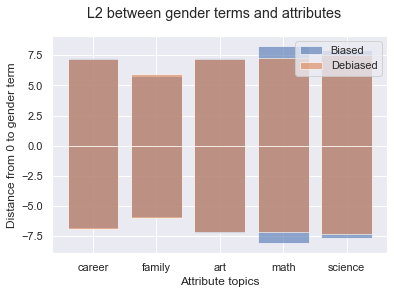

In [41]:
plot_bias("L2")

Despite slight differences in the case of initial data for math and career attributes, the values ​​are basically the same.

#### Cosine distance

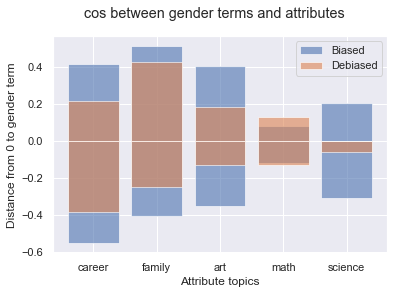

In [42]:
plot_bias("cos")

#### MAC

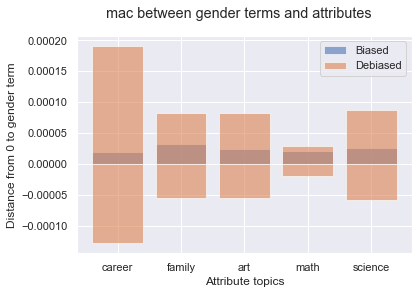

In [43]:
plot_bias("mac")

#### Direct bias

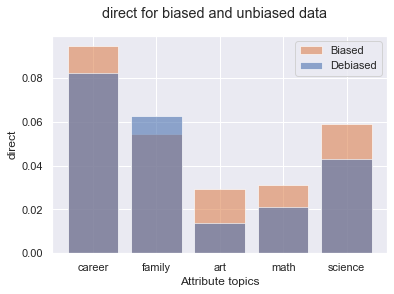

In [44]:
def one_side_plot(metric):
    colors = sns.color_palette()
    cur_data = save_results["biased"][metric]
    cur_data_deb = save_results["debiased"][metric]
    for idx, elem in enumerate(cur_data.keys()):
        line1 = plt.bar(elem, np.abs(cur_data[elem]),  color=colors[1], alpha=0.6)
        line2 = plt.bar(elem, np.abs(cur_data_deb[elem]), color=colors[0], alpha=0.6)
    plt.legend([line1, line2], ['Biased', 'Debiased'])
    plt.suptitle(f"{metric} for biased and unbiased data")
    plt.xlabel("Attribute topics")
    plt.ylabel(f"{metric}")
    plt.show(); 
one_side_plot("direct")

#### WEAT 

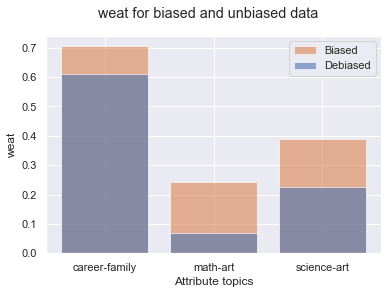

In [45]:
one_side_plot("weat")

#### WEFAT

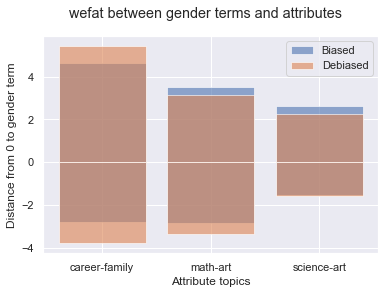

In [46]:
plot_bias("wefat")

#### SAME

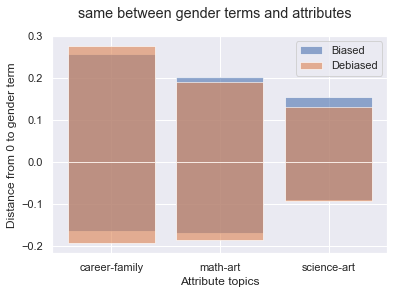

In [47]:
plot_bias("same")

#### ECT

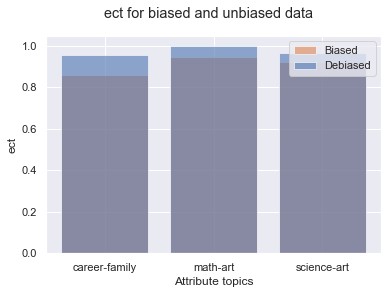

In [48]:
one_side_plot("ect")

#### SVM

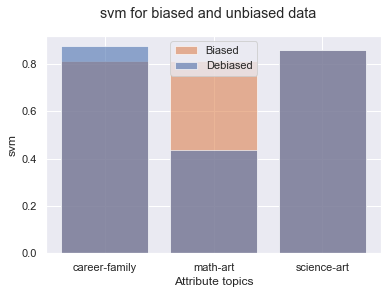

In [49]:
one_side_plot("svm")

#### KMeans

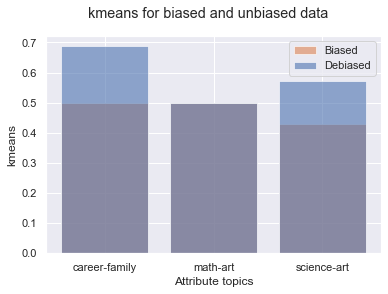

In [50]:
one_side_plot("kmeans")

<hr>

## Bias Analogy Test 

In this test, we analyze the set of embeddings closest in space to words of gender [8]. The closest words are most relevant to the topic of the keyword. Thus, it is possible to reveal the manifestation of stereotypes in embeddings. This method consists of enforcing a probabilitistic definition of unbiased. For examples, P(he|doctor) = P(she|doctor). These probabilities are constructed using the definition of log conditional probability.

In [52]:
path_debiased = os.path.abspath(path_debiased)
model_debiased = KeyedVectors.load_word2vec_format(path_debiased, binary=False)

In [ ]:
path_biased = os.path.abspath(path_biased)
model_biased = KeyedVectors.load_word2vec_format(path_biased, binary=False)

### Biased results

First, let's look at the closest words to the terms of gender. 

In [209]:
model_biased.most_similar(positive=['man'])

[('woman', 0.7664012312889099),
 ('boy', 0.6824869513511658),
 ('teenager', 0.6586929559707642),
 ('teenage_girl', 0.6147903800010681),
 ('girl', 0.5921712517738342),
 ('suspected_purse_snatcher', 0.5716366767883301),
 ('robber', 0.5585118532180786),
 ('Robbery_suspect', 0.5584409236907959),
 ('teen_ager', 0.5549196004867554),
 ('men', 0.5489761233329773)]

In [210]:
model_biased.most_similar(positive=['woman'])

[('man', 0.7664011716842651),
 ('girl', 0.7494640946388245),
 ('teenage_girl', 0.7336829304695129),
 ('teenager', 0.631708562374115),
 ('lady', 0.6288788318634033),
 ('teenaged_girl', 0.6141785979270935),
 ('mother', 0.6076304912567139),
 ('policewoman', 0.6069464087486267),
 ('boy', 0.5975908041000366),
 ('Woman', 0.5770984888076782)]

Next, we will directly consider the analogy test. If he is a programmer, then she? ...

In [213]:
model_biased.most_similar(negative=["he"], 
                                positive=["programmer", "she"])

[('programmers', 0.5277910828590393),
 ('coder', 0.5032481551170349),
 ('Programmer', 0.5006574392318726),
 ('graphic_designer', 0.4812554717063904),
 ('librarian', 0.47027212381362915),
 ('computer_programmer', 0.4556954503059387),
 ('coders', 0.45410919189453125),
 ('scrapbooker', 0.4450640082359314),
 ('copywriter', 0.4329085052013397),
 ('designer', 0.4244496822357178)]

Here we try to evaluate the model's ability to identify gender-related relationships that are not stereotypes.

In [214]:
model_biased.most_similar(negative=["she"], 
                                positive=["queen", "he"])

[('king', 0.7296453714370728),
 ('kings', 0.6000343561172485),
 ('monarch', 0.5462127327919006),
 ('prince', 0.5343004465103149),
 ('crown_prince', 0.4938349425792694),
 ('princes', 0.474705308675766),
 ('royal', 0.4688771367073059),
 ('queens', 0.4687727987766266),
 ('clown_prince', 0.4652290940284729),
 ('palace', 0.45582637190818787)]

### Debiased results

In [201]:
model_debiased.most_similar(positive=['man'])

[('woman', 0.7592735290527344),
 ('boy', 0.7505677938461304),
 ('gentleman', 0.6794666051864624),
 ('teenager', 0.6304978728294373),
 ('Man', 0.604453980922699),
 ('teenage_girl', 0.5809280872344971),
 ('men', 0.5809245705604553),
 ('guy', 0.5636962056159973),
 ('father', 0.5629323124885559),
 ('fella', 0.5623538494110107)]

In [200]:
model_debiased.most_similar(positive=['woman'])

[('man', 0.7592735290527344),
 ('girl', 0.7505679130554199),
 ('teenage_girl', 0.7401474714279175),
 ('lady', 0.6794661283493042),
 ('teenager', 0.6555866003036499),
 ('Woman', 0.6044532060623169),
 ('women', 0.5809244513511658),
 ('mother', 0.5629319548606873),
 ('granny', 0.5623534321784973),
 ('schoolgirl', 0.5613598823547363)]

In [204]:
model_debiased.most_similar(negative=["he"], 
                                positive=["programmer", "she"])

[('programmers', 0.49806249141693115),
 ('Programmer', 0.4634368121623993),
 ('businesswoman', 0.46116703748703003),
 ('coder', 0.4585099220275879),
 ('programer', 0.45570406317710876),
 ('DUDES', 0.45320144295692444),
 ('AUNT', 0.4520288407802582),
 ('MOM', 0.44347575306892395),
 ('computer_programmer', 0.44230544567108154),
 ('Granny', 0.43768078088760376)]

In [205]:
model_debiased.most_similar(negative=["she"], 
                                positive=["queen", "he"])

[('king', 0.9997151494026184),
 ('kings', 0.8014107346534729),
 ('prince', 0.764177680015564),
 ('King', 0.6732096076011658),
 ('monarch', 0.6264094114303589),
 ('Prince', 0.5800058841705322),
 ('crown_prince', 0.5708510279655457),
 ('princes', 0.5330067873001099),
 ('royal', 0.5320427417755127),
 ('fella', 0.5149562358856201)]

The disadvantage of such a test is the need for a subsequent analysis of the results.

## SEAT for BERT 

With the development of methods for obtaining embeddings, including those capable of adapting to the context of the word, concerns about the influence of bias have decreased. However,  studies [11] have shown the imperfection of modern algorithms trained on neutral texts. To test this idea, we implemented the idea of ​​a SEAT[5] method capable of detecting bias in contextualized embeddings. His idea is to formulate simple sentences like "This is science" / "This is a family" containing attribute words that reflect gender stereotypes in society.

In [141]:
from transformers import BertTokenizer, BertModel
import pandas as pd
import torch

model = BertModel.from_pretrained('bert-base-uncased',
           output_hidden_states = True,)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [142]:
def bert_embeds(text, tokenizer, model):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2][1:]

    token_embeddings = hidden_states[-1]
    token_embeddings = torch.squeeze(token_embeddings, dim=0)
    list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]

    return list_token_embeddings

#### SEAT 

In [164]:
bert_seat = {}
for start in ["This is", "There is", "It is"]:
    bert_seat[start] = {}
    for man_attr, woman_attr in tqdm(zip(["career", "math", "science"], ["family", "art", "art"])):
        types = {"targ1": words_m, "targ2": words_f, "attr1": attributes[man_attr], "attr2": attributes[woman_attr]}
        embeds = {}
        for type_ in list(types.keys()):
            embeds[type_] = []
            for text in types[type_]:
                list_token_embeddings = bert_embeds(f"{start} {text}.", tokenizer, model)
                embeds[type_].append(np.stack(list_token_embeddings).mean(0))
        bert_seat[start][f"{man_attr}-{woman_attr}"] = WEAT(np.array(embeds["targ1"]), np.array(embeds["targ2"]), np.array(embeds["attr1"]), 
                                                     np.array(embeds["attr2"]))

3it [00:07,  2.47s/it]
3it [00:07,  2.35s/it]
3it [00:07,  2.34s/it]


In [165]:
bert_seat

{'This is': {'career-family': 0.025276180113760538,
  'math-art': -0.06090538368471543,
  'science-art': 0.03226275139631374},
 'There is': {'career-family': -0.03442389264508128,
  'math-art': 0.12616574829842298,
  'science-art': 0.08994779109297502},
 'It is': {'career-family': 0.02933002958869435,
  'math-art': 0.0831599028467761,
  'science-art': 0.10379126749517043}}

#### Occupations 
Here we are trying to determine the degree of bias relative to professions. We form sentences like "she's a doctor" or "he's a doctor" and test their average with WEAT.

In [171]:
types = {"targ1": words_m, "targ2": words_f, "attr1": list(map(lambda k: "He is " + k, professions)), 
         "attr2":  list(map(lambda k: "She is " + k, professions))}
embeds = {}
for type_ in list(types.keys()):
    embeds[type_] = []
    for text in types[type_]:
        list_token_embeddings = bert_embeds(text, tokenizer, model)
        embeds[type_].append(np.stack(list_token_embeddings).mean(0))
print(WEAT(np.array(embeds["targ1"]), np.array(embeds["targ2"]), np.array(embeds["attr1"]), 
                                             np.array(embeds["attr2"])))

0.12784300658908354


### References 

[1] Bolukbasi, T., Chang, K. W., Zou, J. Y., Saligrama, V., & Kalai, A. T. (2016). Man is to computer programmer as woman is to homemaker? debiasing word embeddings. Advances in neural information processing systems, 29.

[2] Caliskan, A., Bryson, J. J, & Narayanan, A. Semantics derived automatically from language corpora contain human-like biases. Science, 356(6334):183–186, 2017.

[3] Devlin,J., Chang, M.-W., Lee,K., & Toutanova, K. Bert: Pre-training of deep bidirectional transformers for language understanding, 2019.

[4] Manzini,T, Lim, Y. Ch., Tsvetkov,Y., & Black, A.W. Black is to criminal as caucasian is to police: Detecting and removing multiclass bias in word embeddings. CoRR, abs/1904.04047, 2019

[5] May, Ch., Wang. A., Bordia, Sh., Bowman, S.R., Rudinger, R. (2019). On Measuring Social Biases in Sentence Encoders. arXiv:1903.10561.

[6] Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient estimation of word representations in vector space. arXiv preprint arXiv:1301.3781.

[7] Pennington, J., Socher,R., & Manning, Ch, D. (2014). Glove: Global vectors for word representation. In Proceedings of the 2014 conference on empirical methods in natural language processing (EMNLP), pages 1532–1543

[8] Schröder, S., Schulz, A., Kenneweg, Ph., Feldhans, R., Hinder, F., & Hammer, B. (2021). Evaluating Metrics for Bias in Word Embeddings. arXiv:2111.07864

[9] Dev, S.,  Li, T., Phillips,J.M., Srikumar, V. (2019). On Measuring and Mitigating Biased Inferences of Word Embeddings. arXiv:1908.09369. 

[10] Swinger,N., De-Arteaga, M., Heffernan IV, N.T., Leiserson, M. DM, & Kalai, A.T. (2019). What are the biases in my word embedding? In Proceedings of the 2019 AAAI/ACM Conference on AI, Ethics, and Society, pages 305–311

[11] Zhao,J., Wang,T., Yatskar,M., Cotterell,R., Ordonez,V., & Chang, K.-W. (2019). Gender bias in contextualized word embeddings. CoRR, abs/1904.03310